In [13]:
import cv2
import numpy as np

# Load the image in grayscale
img = cv2.imread('test2.jpg', 0)

# Apply thresholding to create a binary image
ret, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Define a kernel for morphological operations
kernel = np.ones((5,5), np.uint8)

# Perform erosion to remove small noise
erosion = cv2.erode(thresh1, kernel, iterations=1)

# Apply Gaussian blur to smooth the image
blur = cv2.GaussianBlur(img, (5,5), 0)

# Edge detection using Canny
edges = cv2.Canny(blur, 100, 200)

# Apply Laplacian and Sobel operators
laplacian = cv2.Laplacian(edges, cv2.CV_8UC1)
sobely = cv2.Sobel(laplacian, cv2.CV_8UC1, 0, 1, ksize=5)

# Apply dilation and erosion to enhance features
dilated = cv2.dilate(sobely, kernel, iterations=1)
erosion = cv2.erode(dilated, kernel, iterations=1)

# Find contours (OpenCV 4.x)
contours, hierarchy = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Keep the 10 largest contours
cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
screenCnt = None

for c in cnts:
    # Approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.05 * peri, True)
    
    # If the approximated contour has three points, it's a road marking
    if len(approx) == 3:
        screenCnt = approx
        break

# Draw contours if a valid contour is found
if screenCnt is not None:
    img_color = cv2.imread('test2.jpg')  # Reload the image in color
    cv2.drawContours(img_color, [screenCnt], -1, (0, 255, 0), 3)
    cv2.imshow("Road markings", img_color)
else:
    print("No road marking detected.")

cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
#Importing Packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from moviepy.video.io.VideoFileClip import VideoFileClip

import cv2
import numpy as np
#from goprocam import GoProCamera
#from goprocam import constants


vidcap = cv2.VideoCapture("data/video1.mp4")
#vidcap = cv2.VideoCapture("udp://10.5.5.9:8554")
success,gopro = vidcap.read()
success = True
i=0

lx1 = 0
lx2 = 0
ly1 = 0
ly2 = 0
rx1 = 0
rx2 = 0
ry1 = 0
ry2 = 0
present = 0


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform to the grayscaled image"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # Defining a blank mask to start with
    mask = np.zeros_like(img)

    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # Filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function defines and draws `lines` with `color` and `thickness`.
    """
    # Initializing empty arrays
    right_xpoints=[]
    right_ypoints=[]
    l_xpoints=[]
    l_ypoints=[]

    sloper = []
    slopel = []
    slopes = []

    br = []
    bl = []
    bs = []
    global present, lx1 , lx2 , ly1 , ly2 , rx1 , rx2 , ry1 , ry2
    if lines is None:
        #left
        print('lol')
        cv2.line(img, (lx1, ly1), (lx2, ly2), [0, 255, 0], 6)
        #right
        cv2.line(img, (rx1, ry1), (rx2, ry2), [0, 255, 0], 6)

        #avgx1, avgy1, avgx2, avgy2 = avgLeft
        #cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 8) #draw left line
        #avgx3, avgy3, avgx4, avgy4 = avgRight
        #cv2.line(img, (int(avgx3), int(avgy3)), (int(avgx4), int(avgy4)), [255,255,255], 8) #draw right line
        #cv2.line(img, (int((int(avgx3)+int(avgx1))/2), int((int(avgy3)+int(avgy1))/2)), (int((int(avgx4)+int(avgx2))/2), int((int(avgy4)+int(avgy2))/2)), [255,255,255], 8) #draw right line
        return



    for line in lines:
        for x1,y1,x2,y2 in line:
            size = math.hypot(x2 - x1, y2 - y1)
            #Finding the slope and intercept value
            slope = ((y2-y1)/(x2-x1))
            parameters = np.polyfit((x1, x2), (y1, y2), 1)

            #Filter the lines based on the slope value as right and left lanes
            if (slope > 0.3 and ((x1 and x2) > 320)):
              #right lane
                presentl = 1
                sloper.append(slope)
                br.append(parameters[1])
                #Adding right hough lines
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            elif (slope < -0.3 and ((x1 and x2) < 320)):
                #left lane
                presentr = 1
                slopel.append(slope)
                bl.append(parameters[1])
                #Adding left hough lines
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#            elif (-0.2 < slope < 0.2 and ((y1 and y2 )< 350 )):
#                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    #Calculating mean slope and intercept values

    #right lane
    meanSloper = np.mean(sloper)
    meanBr = np.mean(br)

    if (present == 0):
         cv2.line(img, (rx1, ry1), (rx2, ry2), [0, 255, 0], 6)
         cv2.line(img, (lx1, ly1), (lx2, ly2), [0, 255, 0], 6)
    #finding two points to fit the right lane line
    x1 = 640
    if(np.isnan(meanSloper) or np.isnan(meanBr)):
      pass
    else:

        y1 = meanSloper * x1 + meanBr
        y2 = 260
        x2 = ( y2 - meanBr ) / meanSloper
        #Plotting the right lane
        if(math.isfinite(y1) and math.isfinite(x2)):
            cv2.line(img, (x1, int(y1)), (int(x2), y2), [0, 255, 0], 6)
        #print('lol')

        #right

        lx1 = x1
        lx2 = int(x2)
        ly1 = int(y1)
        ly2 = y2
    #left lane
    meanSlopel = np.mean(slopel)
    meanBl = np.mean(bl)

    #finding two points to fit the left lane line
    x1 = 0
    if(np.isnan(meanSlopel) or np.isnan(meanBl) or math.isinf(meanSlopel) or math.isinf(meanBl)):
      pass
    else:
        y1 = meanSlopel * x1 + meanBl
        y2 = 260
        x2 = ( y2 - meanBl ) / meanSlopel
        #Plotting the left lane
        if(math.isfinite(y1) and math.isfinite(x2)):
            cv2.line(img, (x1, int(y1)), (int(x2), y2), [0, 255, 0], 6)

        rx1 = x1
        rx2 = int(x2)
        ry1 = int(y1)
        ry2 = y2


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Takes the outout of canny as the input image and
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, a=0.8, b=1., c=0.):
    """
    Takes the output image with hough lines as input

    The result image is computed as follows:

    initial_img * a + img * ß + ?
    """
    return cv2.addWeighted(initial_img, a, img, b, c)

# Import everything needed for creating the video clips


def process_image(image):
    # Resizing the input image to a more resonable size for processing
    image = cv2.resize(image, (640, 480), interpolation = cv2.INTER_AREA)





    # Blur to avoid edges from noise
    blurredImage = gaussian_blur(image, 7)

    # Detect edges using canny
    edgesImage = canny(blurredImage, 100, 140)

    # Mark out the vertices for region of interest
    vertices = np.array( [[
                [0, 480],
                [0, 320],
                [200, 280],
                [520, 260],
                [640, 300],
                [640, 480]
            ]], dtype=np.int32 )

    # Mask the canny output with region of interest
    regionInterestImage = region_of_interest(edgesImage, vertices)

    # Drawing the hough lines in the Masked Canny image
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 35, 15, 100)

    # Test detected edges by uncommenting this
    # return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)

    # Draw output on top of original
    return weighted_img(lineMarkedImage, image)

while success:
  i=i+1

  presentr = 0
  presentl = 0
  if  gopro is not None:

      mah = process_image(gopro)
      cv2.imshow('frame',mah)
    #   cv2.imwrite("frame"+str(i)+".jpg", mah)
      key = cv2.waitKey(1)
      if(key == ord('q')):
          break
  success,gopro = vidcap.read()

  print('Read a new frame: ', success)

vidcap.release()
cv2.destroyAllWindows()

In [1]:

import numpy as np
import cv2 as cv2

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Routine to fix 
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))



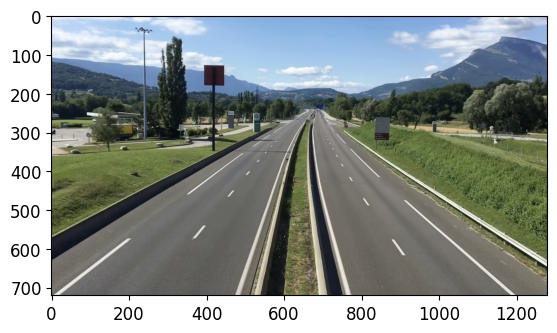

In [47]:


image = cv2.imread('test4.jpg')
plt.imshow(fixColor(image))


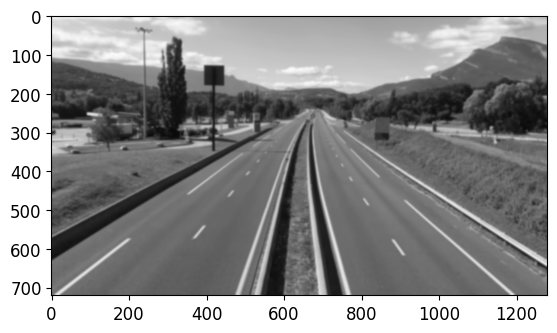

In [30]:


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11,11), 0)
plt.imshow(fixColor(gray))



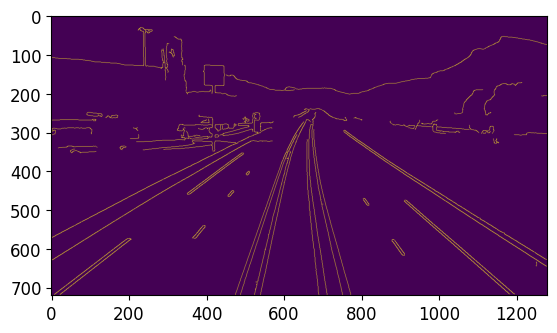

In [31]:


edges = cv2.Canny(gray, 50, 200)
plt.imshow(edges)



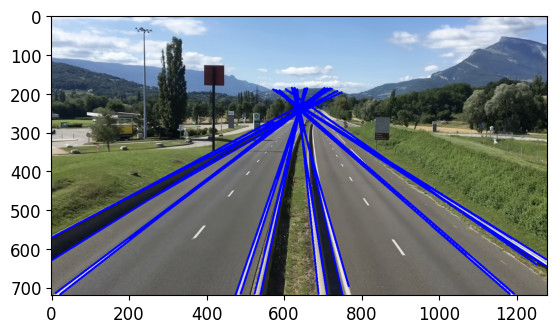

In [32]:
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold = 100, minLineLength=5, maxLineGap=250)

for line in lines:
    x1, y1, x2, y2 = line[0]
    if (y1 > 400 or y2 > 400): #Filter out the lines in the top of the image
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

plt.imshow(fixColor(image))



In [40]:

def fixColor(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def auto_blur_selection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = np.var(gray)
    print(variance)  # Measure image variance
    
    if variance > 1500:  
        ksize = 3  # High-detail image (sharp edges)
    elif variance > 1000:  
        ksize = 5  # Moderate details
    elif variance > 500:
        ksize = 7  # Slightly blurred
    else:
        ksize = 11  # Very noisy or soft edges
    
    return (ksize, ksize)  # Return optimal blur kernel size


2971.6978623452596


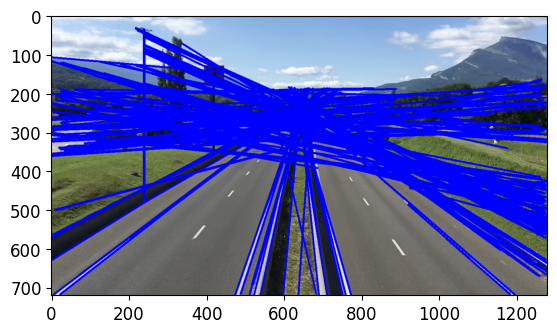

In [ ]:
# Apply Gaussian Blur
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
best_blur = auto_blur_selection(image)
blurred = cv2.GaussianBlur(gray, best_blur, 0)

edges = cv2.Canny(blurred, 50, 200)


# Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=10, maxLineGap=200)

# Draw lines
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

plt.imshow(fixColor(image))
plt.show()


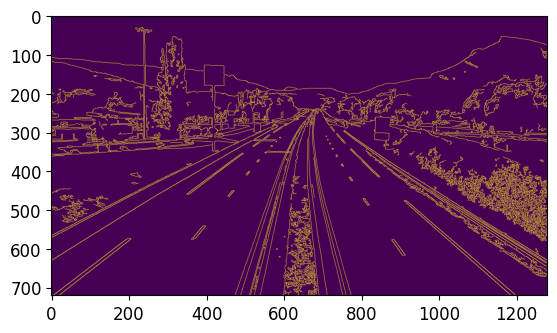

In [49]:
plt.imshow(edges)


In [3]:
import cv2
from geopy.distance import geodesic

# Initialize variables to store two points
points = []

def click_event(event, x, y, flags, param):
    global points

    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print(f"Clicked at: ({x}, {y})")

        # If two points are selected, calculate distance
        if len(points) == 2:
            # Example: Convert pixel points to lat/lon (Replace with actual conversion if available)
            latlon1 = pixel_to_latlon(points[0])
            latlon2 = pixel_to_latlon(points[1])

            distance = geodesic(latlon1, latlon2).meters
            print(f"Distance: {distance:.2f} meters")

            # Draw a line between points and show distance
            cv2.line(frame_resized, points[0], points[1], (0, 255, 0), 2)
            cv2.putText(frame_resized, f"{distance:.2f}m", (points[0][0], points[0][1] - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

            points = []  # Reset for next selection

def pixel_to_latlon(pixel):
    """
    Convert pixel coordinates to latitude/longitude.
    You need a mapping function depending on how your video is related to real-world coordinates.
    """
    # Example static mapping (Replace with real conversion)
    lat = 35.6895 + (pixel[1] * 0.00001)  # Example: Fake conversion formula
    lon = 139.6917 + (pixel[0] * 0.00001)
    return (lat, lon)

# Open video file
video_path = 'data/highway.mp4'  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

cv2.namedWindow('Video', cv2.WINDOW_NORMAL)  # Allow window resizing
cv2.setMouseCallback('Video', click_event)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame or end of video.")
        break

    # Resize frame to 1920x1080
    frame_resized = cv2.resize(frame, (1920, 1080))

    cv2.imshow('Video', frame_resized)
    if cv2.waitKey(1) & 0xFF == 27:  # Press ESC to exit
        break

cap.release()
cv2.destroyAllWindows()


Clicked at: (739, 275)
Clicked at: (895, 269)
Distance: 141.36 meters
Clicked at: (786, 572)
Clicked at: (213, 551)
Distance: 519.14 meters
Error: Could not read frame or end of video.


In [15]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import simpledialog
import math

class VideoDistanceCalculator:
    def __init__(self, video_path):
        self.video_path = video_path
        self.cap = None
        self.frame = None
        self.points = []
        self.scale_factor = None  # Distance in meters per pixel
        self.reference_distance = None  # Real-world reference distance in meters
        self.reference_points = []  # Points used for calibration
        self.current_frame_idx = 0
        self.total_frames = 0
        self.paused = False
        self.target_width = 1280
        self.target_height = 720

        
    def calibrate_scale(self):
        """Calibrate the scale using two points and a known distance"""
        print("Please click on two points with a known real-world distance between them.")
        print("After selecting the points, you'll be asked to enter the actual distance.")
        
        # Temporary event handling for calibration
        cv2.setMouseCallback('Video Distance Calculator', self.collect_reference_points)
        
        while len(self.reference_points) < 2:
            if self.frame is not None:
                display_frame = self.frame.copy()
                
                # Draw existing reference points
                for i, point in enumerate(self.reference_points):
                    cv2.circle(display_frame, point, 5, (0, 0, 255), -1)
                    cv2.putText(display_frame, f"Ref {i+1}", 
                                (point[0]+10, point[1]), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                
                cv2.imshow('Video Distance Calculator', display_frame)
            
            if cv2.waitKey(30) & 0xFF == 27:  # ESC key
                return False
                
        # Calculate pixel distance between reference points
        dx = self.reference_points[0][0] - self.reference_points[1][0]
        dy = self.reference_points[0][1] - self.reference_points[1][1]
        pixel_distance = math.sqrt(dx*dx + dy*dy)
        
        # Ask for real-world distance
        root = tk.Tk()
        root.withdraw()
        self.reference_distance = simpledialog.askfloat(
            "Reference Distance", 
            "Enter the real-world distance between the two points (in meters):",
            minvalue=0.1
        )
        
        if self.reference_distance:
            self.scale_factor = self.reference_distance / pixel_distance
            print(f"Calibration complete: {self.scale_factor:.6f} meters per pixel")
            
            # Reset event callback for normal operation
            cv2.setMouseCallback('Video Distance Calculator', self.add_point)
            return True
        else:
            print("Calibration cancelled")
            return False
    
    def collect_reference_points(self, event, x, y, flags, param):
        """Mouse callback function for collecting reference points"""
        if event == cv2.EVENT_LBUTTONDOWN and len(self.reference_points) < 2:
            self.reference_points.append((x, y))
            print(f"Reference point {len(self.reference_points)} added at ({x}, {y})")
    
    def add_point(self, event, x, y, flags, param):
        """Mouse callback function for adding distance measurement points"""
        if event == cv2.EVENT_LBUTTONDOWN:
            self.points.append((x, y))
            print(f"Point {len(self.points)} added at ({x}, {y})")
    
    def calculate_distances(self):
        """Calculate distances between consecutive points"""
        if len(self.points) < 2:
            return []
            
        distances = []
        total_distance = 0
        
        for i in range(len(self.points) - 1):
            p1 = self.points[i]
            p2 = self.points[i + 1]
            
            # Calculate pixel distance
            dx = p1[0] - p2[0]
            dy = p1[1] - p2[1]
            pixel_distance = math.sqrt(dx*dx + dy*dy)
            
            # Convert to real-world distance
            real_distance = pixel_distance * self.scale_factor
            total_distance += real_distance
            
            distances.append({
                'segment': f"{i+1}-{i+2}",
                'points': (p1, p2),
                'distance': real_distance,
                'cumulative': total_distance
            })
            
        return distances
    
    def resize_frame(self, frame):
        """Resize frame to target dimensions"""
        return cv2.resize(frame, (self.target_width, self.target_height))
    
    def run(self):
        """Main execution function"""
        self.cap = cv2.VideoCapture(self.video_path)
        if not self.cap.isOpened():
            print("Error opening video file!")
            return
            
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        

        
        cv2.namedWindow('Video Distance Calculator')
        
        # Read the initial frame
        ret, frame = self.cap.read()
        if not ret:
            print("Failed to read video")
            return
        
        # Resize frame to target dimensions
        self.frame = self.resize_frame(frame)
            
        # Set up the calibration
        if not self.calibrate_scale():
            self.cap.release()
            cv2.destroyAllWindows()
            return
            
        while True:
            if not self.paused:
                ret, frame = self.cap.read()
                
                if not ret:
                    # End of video, loop back
                    self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                    ret, frame = self.cap.read()
                    self.current_frame_idx = 0
                else:
                    self.current_frame_idx += 1
                
                # Resize frame to target dimensions
                self.frame = self.resize_frame(frame)
            
            # Create a copy to draw on
            display_frame = self.frame.copy()
            
            # Draw reference points and line
            for i, point in enumerate(self.reference_points):
                cv2.circle(display_frame, point, 5, (0, 0, 255), -1)
                cv2.putText(display_frame, f"Ref {i+1}", (point[0]+10, point[1]), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            
            if len(self.reference_points) == 2:
                cv2.line(display_frame, self.reference_points[0], self.reference_points[1], 
                         (0, 0, 255), 2)
                cv2.putText(display_frame, 
                            f"{self.reference_distance:.2f}m", 
                            (int((self.reference_points[0][0] + self.reference_points[1][0])/2), 
                             int((self.reference_points[0][1] + self.reference_points[1][1])/2) - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            
            # Draw measurement points and lines
            for i, point in enumerate(self.points):
                cv2.circle(display_frame, point, 5, (0, 255, 0), -1)
                cv2.putText(display_frame, str(i+1), (point[0]+10, point[1]), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            # Draw lines between points
            distances = self.calculate_distances()
            for dist in distances:
                p1, p2 = dist['points']
                cv2.line(display_frame, p1, p2, (255, 0, 0), 2)
                
                # Display distance on the line
                mid_x = int((p1[0] + p2[0]) / 2)
                mid_y = int((p1[1] + p2[1]) / 2)
                cv2.putText(display_frame, f"{dist['distance']:.2f}m", 
                            (mid_x, mid_y - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
            # Display total distance
            if distances:
                total = distances[-1]['cumulative']
                cv2.putText(display_frame, f"Total Distance: {total:.2f}m", 
                            (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            # Display playback info
            cv2.putText(display_frame, f"Frame: {self.current_frame_idx}/{self.total_frames} {'(Paused)' if self.paused else ''}", 
                        (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            # Display resolution info
            cv2.putText(display_frame, f"Resolution: {self.target_width}x{self.target_height}", 
                        (20, 85), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            # Show instructions
            instructions = [
                "Controls:",
                "Click: Add point",
                "R: Reset points",
                "Space: Pause/Resume",
                "ESC: Exit"
            ]
            
            for i, line in enumerate(instructions):
                cv2.putText(display_frame, line, (20, 115 + i*25), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), 1)
            
            cv2.imshow('Video Distance Calculator', display_frame)
            
            key = cv2.waitKey(30) & 0xFF
            if key == 27:  # ESC key
                break
            elif key == ord(' '):  # Space bar
                self.paused = not self.paused
            elif key == ord('r'):  # R key
                self.points = []
        
        self.cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    video_path = "data/vehicles.mp4"  # Replace with your video file path
    calculator = VideoDistanceCalculator(video_path)
    calculator.run()

Please click on two points with a known real-world distance between them.
After selecting the points, you'll be asked to enter the actual distance.
Reference point 1 added at (428, 248)
Reference point 2 added at (739, 248)
Calibration complete: 0.080386 meters per pixel
Point 1 added at (428, 246)
Point 2 added at (8, 578)


In [ ]:
import cv2

from ultralytics import solutions

cap = cv2.VideoCapture("data/video1.mp4")
assert cap.isOpened(), "Error reading video file"

# Video writer
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
video_writer = cv2.VideoWriter("speed_management.avi", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# speed region points
line_pts = [(0, 360), (1280, 360)]

# Initialize speed estimation object
speedestimator = solutions.SpeedEstimator(
    show=True,  # display the output
    model="yolo11n.pt",  # path to the YOLO11 model file.
    region=speed_region,  # pass region points
    # classes=[0, 2],  # estimate speed of specific classes.
    # line_width=2,  # adjust the line width for bounding boxes
)

# Process video
while cap.isOpened():
    success, im0 = cap.read()

    if not success:
        print("Video frame is empty or processing is complete.")
        break

    results = speedestimator(im0)

    # print(results)  # access the output

    video_writer.write(results.plot_im)  # write the processed frame.

cap.release()
video_writer.release()
cv2.destroyAllWindows()  # destroy all opened windows

: 